# AFINN Sentiment Analysis

This notebook demonstrates using the AFINN lexicon to perform sentiment analysis on customer reviews. AFINN assigns integer sentiment scores to words (typically from -5 to +5). We compute a total score per review and map it to a sentiment label.

## Step 1 - Import Dependencies

Import pandas for data handling and Afinn from the afinn library for lexicon-based sentiment scoring.

In [1]:
import pandas as pd
from afinn import Afinn

## Step 2 - Get Documents

Read the reviews Excel sheet into a pandas DataFrame. Calling `head()` shows the first few rows to verify the data loaded correctly.

In [2]:
reviews_df = pd.read_excel('data/reviews.xlsx')
reviews_df.head()

,Review ID,Source,Review Text
0,1,Amazon,This water filter is amazing! Setup was super ...
1,2,Amazon,"It's okay. The water tastes fine, but the app ..."
2,3,Amazon,DO NOT BUY! This thing started leaking all ove...
3,4,Amazon,Really happy with this purchase. The water qua...
4,5,Amazon,Does what it says. Water tastes alright. Not a...


## Step 3 - Initialize AFINN

Create an instance of `Afinn`, which provides the `score` method to compute a sentiment score for a given text by summing word scores.

In [3]:
afinn = Afinn()

## Step 4 - Define Scoring Function

The `afinn_sentiment` function:
- Converts the input to a string to avoid issues with NaN/None values.
- Uses `afinn.score(text)` to get a numeric score (negative = negative sentiment, positive = positive sentiment, 0 = neutral).
- Maps the score to a simple label: Positive, Negative, or Neutral.

It returns a pandas Series with two values: the numeric score and the label.

In [4]:
def afinn_sentiment(text):
    score = afinn.score(str(text))
    if score > 0:
        label = "Positive"
    elif score < 0:
        label = "Negative"
    else:
        label = "Neutral"
    # Return a labeled Series so resulting DataFrame has explicit column names
    return pd.Series({"AFINN Score": score, "AFINN Sentiment": label})

## Step 5 - Results

Apply the function to the "Review Text" column to produce two new columns: "AFINN Score" and "AFINN Sentiment". Then print the resulting series for quick inspection.

In [5]:
# Apply returns a labeled Series; assign directly into the DataFrame and keep a copy in `results`
results = reviews_df[["AFINN Score", "AFINN Sentiment"]] = reviews_df["Review Text"].apply(afinn_sentiment)
print(results)

       0         1
0   15.0  Positive
1    2.0  Positive
2   -1.0  Negative
3   13.0  Positive
4    1.0  Positive
5    2.0  Positive
6    3.0  Positive
7    7.0  Positive
8    6.0  Positive
9    8.0  Positive
10   7.0  Positive
11  -3.0  Negative
12  10.0  Positive
13   4.0  Positive
14   7.0  Positive
15   3.0  Positive
16   5.0  Positive
17   6.0  Positive
18   1.0  Positive
19   8.0  Positive
20   0.0   Neutral
21   7.0  Positive
22   3.0  Positive
23   8.0  Positive
24   5.0  Positive
25   2.0  Positive
26   4.0  Positive
27   4.0  Positive
28   1.0  Positive
29  10.0  Positive
30   8.0  Positive
31   3.0  Positive
32   6.0  Positive
33   3.0  Positive
34   5.0  Positive
35   5.0  Positive
36   3.0  Positive
37  -2.0  Negative
38   7.0  Positive
39   9.0  Positive
40   0.0   Neutral
41   5.0  Positive
42   2.0  Positive
43   2.0  Positive
44   8.0  Positive
45  -2.0  Negative
46  -3.0  Negative
47   1.0  Positive
48  -1.0  Negative
49  -5.0  Negative


### Notes

- AFINN is lexicon-based and does not understand context; negation handling is simple and may miss nuances.
- Consider preprocessing (lowercasing, removing punctuation) if your data is noisy.
- Scores are additive; very long texts can accumulate larger magnitudes.
- For more advanced handling (e.g., sarcasm, context), consider model-based approaches.

## Step 6 - Visualization Setup

Import Matplotlib and Seaborn for plotting and set a clean style/palette for consistent visuals throughout the notebook.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
plt.style.use('ggplot')
sns.set_palette("bright")

## Step 7 - Create Columns and Labels

Ensure the computed AFINN outputs are in dedicated DataFrame columns. Then derive a simple sentiment label using thresholds on the numeric score: > 0 = Positive, < 0 = Negative, otherwise 0 = Neutral. Finally, preview the resulting columns.

In [10]:
# Columns were created in Step 5; ensure they exist (no-op if already present)
# For visualization, also create a normalized score per token length to reduce length bias
reviews_df['token_count'] = reviews_df['Review Text'].astype(str).str.split().apply(len)
reviews_df['AFINN Score Normalized'] = reviews_df.apply(lambda r: r['AFINN Score'] / r['token_count'] if r['token_count'] > 0 else 0, axis=1)

# Re-derive a label for clarity (same mapping as earlier)
reviews_df['AFINN Label'] = reviews_df['AFINN Score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

reviews_df[['AFINN Score', 'AFINN Score Normalized', 'AFINN Label']].head()

,AFINN Score,AFINN Score Normalized,AFINN Label
0,15.0,0.348837,Positive
1,2.0,0.064516,Positive
2,-1.0,-0.035714,Negative
3,13.0,0.371429,Positive
4,1.0,0.040000,Positive


## Step 8 - Distribution Plots

Plot the distributions of raw AFINN scores and length-normalized scores across the dataset. We use 30 bins and overlay a KDE; a vertical line at 0 marks neutrality.

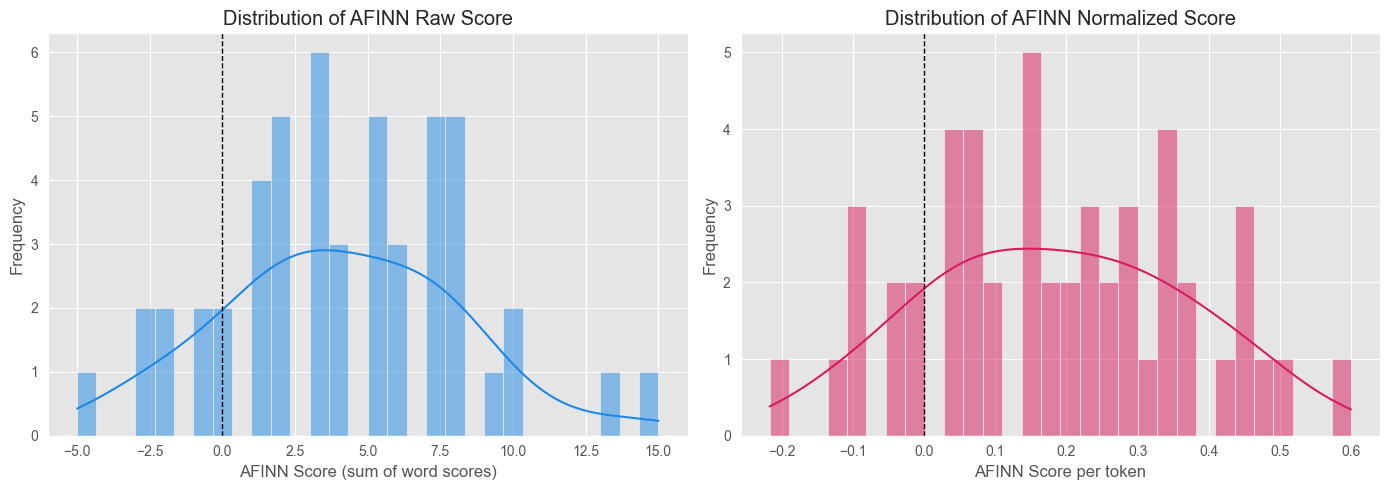

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Raw score distribution
sns.histplot(reviews_df['AFINN Score'], bins=30, kde=True, ax=axes[0], color='#1E88E5')
axes[0].set_title('Distribution of AFINN Raw Score')
axes[0].set_xlabel('AFINN Score (sum of word scores)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
# Normalized score distribution
sns.histplot(reviews_df['AFINN Score Normalized'], bins=30, kde=True, ax=axes[1], color='#D81B60')
axes[1].set_title('Distribution of AFINN Normalized Score')
axes[1].set_xlabel('AFINN Score per token')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

## Step 9 - Sentiment Breakdown

Visualize the count of reviews by AFINN label (Positive/Neutral/Negative). This mirrors the categorical overview in other notebooks.

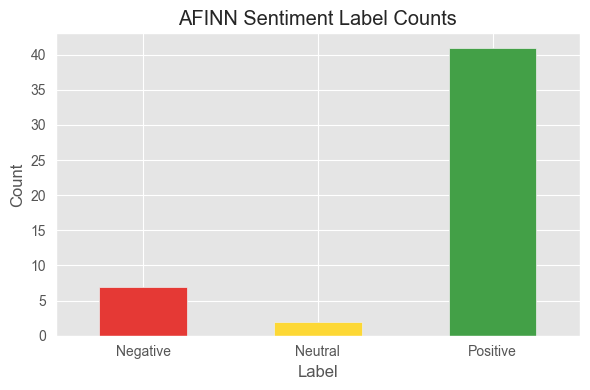

In [12]:
label_order = ['Negative', 'Neutral', 'Positive']
counts = reviews_df['AFINN Label'].value_counts().reindex(label_order)
ax = counts.plot(kind='bar', color=['#E53935', '#FDD835', '#43A047'], figsize=(6,4))
ax.set_title('AFINN Sentiment Label Counts')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Step 10 - Score vs. Length

AFINN sums word scores; longer texts can accumulate larger magnitudes. Plot raw score versus token count to inspect length effects. Color by label.

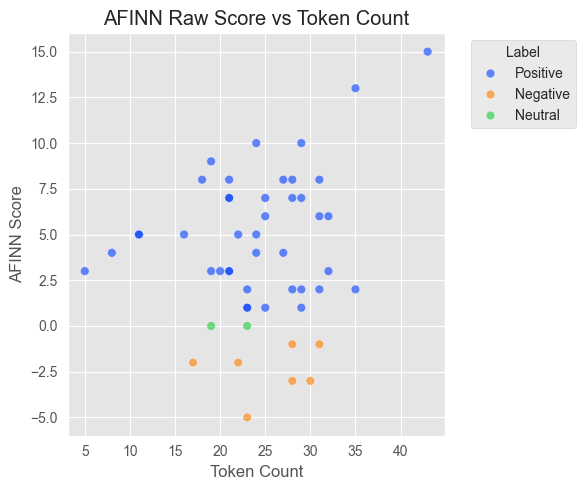

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=reviews_df, x='token_count', y='AFINN Score', hue='AFINN Label', alpha=0.6, s=40)
ax.set_title('AFINN Raw Score vs Token Count')
ax.set_xlabel('Token Count')
ax.set_ylabel('AFINN Score')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()